In [1]:
import numpy as np
from astropy.table import Table

import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization,Dropout
from sklearn.preprocessing import StandardScaler

2025-03-07 15:50:39.448910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = Table.read('data_matched_step2_newz_sm.csv', format='ascii.csv', header_start=0, data_start=1)
print(data.colnames)

['MJD', 'PLATE', 'FIBERID', 'z', 'VDISP', 'VDISP_ERR', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y', 'flux_w1', 'o21', 'o21_err', 'o22', 'o22_err', 'hb', 'hb_err', 'o3', 'o3_err', 'o1', 'o1_err', 'ha', 'ha_err', 'n2', 'n2_err', 's21', 's21_err', 's22', 's22_err', 'sigma_o3', 'sigma_o3_err', 'sigma_hb', 'sigma_hb_err', 'sm']


In [11]:
def load_and_preprocess_data(filename):
    data = Table.read(filename, format='ascii.csv', header_start=0, data_start=1)

    # ensure no NaN
    valid_sigma_o3_err = (data['sigma_o3_err'] > 0) & np.isfinite(data['sigma_o3_err'])  # valid error values
    valid_sigma_o3 = np.isfinite(data['sigma_o3'])  # valid sigma_o3 values
    valid_data = valid_sigma_o3 & valid_sigma_o3_err  # only keep valid data points
    
    # selection criteria
    ind1 = np.where(data['o3'] / data['o3_err'] > 3)
    ind2 = np.where((data['o21'] + data['o22']) / np.sqrt(data['o21_err']**2 + data['o22_err']**2) > 3)
    ind3 = np.where(data['hb'] / data['hb_err'] > 3)
    ind4 = np.where(data['ha'] / data['ha_err'] > 3)
    ind5 = np.where(data['s21'] / data['s21_err'] > 3)
    ind6 = np.where(valid_data & (data['sigma_o3'] / data['sigma_o3_err'] > 3))  # Only include valid data
    ind7 = np.where(data['VDISP'] > 0.)
    ind8 = np.where(data['mag_u'] > 10.)

    # combine all indices
    ind = np.array(list(set(ind1[0]) & set(ind2[0]) & set(ind3[0]) & set(ind4[0]) & set(ind5[0]) & set(ind6[0]) & set(ind7[0]) & set(ind8[0])))
    
    # split sets
    n_source = len(ind)
    print(n_source)
    n_split = int(n_source * 0.7)
    ind_train, ind_test = ind[:n_split], ind[n_split:]
    print(len(ind_train))

    # feature arrays 
    features_train = {
        'O2_index': np.log10((data['o21'][ind_train] + data['o22'][ind_train]) / data['hb'][ind_train]),
        'O3_index': np.log10(data['o3'][ind_train] / data['hb'][ind_train]),
        'sigma_o3': np.log10(data['sigma_o3'][ind_train]),
        'sigma_star': np.log10(data['VDISP'][ind_train]),
        'u_g': data['mag_u'][ind_train] - data['mag_g'][ind_train],
        'g_r': data['mag_g'][ind_train] - data['mag_r'][ind_train],
        'r_i': data['mag_r'][ind_train] - data['mag_i'][ind_train],
        'i_z': data['mag_i'][ind_train] - data['mag_z'][ind_train],
    }

    features_test = {
        'O2_index': np.log10((data['o21'][ind_test] + data['o22'][ind_test]) / data['hb'][ind_test]),
        'O3_index': np.log10(data['o3'][ind_test] / data['hb'][ind_test]),
        'sigma_o3': np.log10(data['sigma_o3'][ind_test]),
        'sigma_star': np.log10(data['VDISP'][ind_test]),
        'u_g': data['mag_u'][ind_test] - data['mag_g'][ind_test],
        'g_r': data['mag_g'][ind_test] - data['mag_r'][ind_test],
        'r_i': data['mag_r'][ind_test] - data['mag_i'][ind_test],
        'i_z': data['mag_i'][ind_test] - data['mag_z'][ind_test],
    }

    # assign labels
    type_arr_train = np.full(len(ind_train), -999)
    type_arr_test = np.full(len(ind_test), -999)

    N2_index_train = np.log10(data['n2'][ind_train] / data['ha'][ind_train])
    S2_index_train = np.log10((data['s21'][ind_train] + data['s22'][ind_train]) / data['ha'][ind_train])
    O3_index_train = np.log10(data['o3'][ind_train] / data['hb'][ind_train])

    N2_index_test = np.log10(data['n2'][ind_test] / data['ha'][ind_test])
    S2_index_test = np.log10((data['s21'][ind_test] + data['s22'][ind_test]) / data['ha'][ind_test])
    O3_index_test = np.log10(data['o3'][ind_test] / data['hb'][ind_test])

    # Star-Forming Class (SF)
    ind_sf1_train = np.where(O3_index_train <= (0.61/(N2_index_train - 0.05) + 1.3))
    ind_sf2_train = np.where(N2_index_train < 0.)
    ind_sf_train = np.array(list(set(ind_sf1_train[0]) & set(ind_sf2_train[0])))

    # AGN Class
    ind_AGN1_train = np.where(O3_index_train > (0.61/(N2_index_train - 0.47) + 1.19))
    ind_AGN2_train = np.where(N2_index_train >= 0.)
    ind_AGN3_train = np.where(O3_index_train > 1.89 * S2_index_train + 0.76)
    ind_AGN_train = np.array(list(set(ind_AGN1_train[0]) | (set(ind_AGN2_train[0]) & set(ind_AGN3_train[0]))))

    # LINER Class
    ind_liner1_train = np.where(O3_index_train > (0.61/(N2_index_train - 0.47) + 1.19)) 
    ind_liner2_train = np.where(O3_index_train <= 1.89 * S2_index_train + 0.76)
    ind_liner_train = np.array(list(set(ind_liner1_train[0]) & set(ind_liner2_train[0])))

    # Composite Class (Comp)
    ind_comp1_train = np.where(O3_index_train < (0.61/(N2_index_train - 0.47) + 1.19))
    ind_comp2_train = np.where(O3_index_train > (0.61/(N2_index_train - 0.05) + 1.3))
    ind_comp_train = np.array(list(set(ind_comp1_train[0]) & set(ind_comp2_train[0])))

    # Assign Corrected Labels
    type_arr_train[ind_sf_train] = 1
    type_arr_train[ind_comp_train] = 2
    type_arr_train[ind_AGN_train] = 3
    type_arr_train[ind_liner_train] = 4

    N2_index_train = np.log10(data['n2'][ind_test] / data['ha'][ind_test])
    S2_index_train = np.log10((data['s21'][ind_test] + data['s22'][ind_test]) / data['ha'][ind_test])
    O3_index_train = np.log10(data['o3'][ind_test] / data['hb'][ind_test])

    N2_index_test = np.log10(data['n2'][ind_test] / data['ha'][ind_test])
    S2_index_test = np.log10((data['s21'][ind_test] + data['s22'][ind_test]) / data['ha'][ind_test])
    O3_index_test = np.log10(data['o3'][ind_test] / data['hb'][ind_test])

    # Star-Forming Class (SF)
    ind_sf1_test = np.where(O3_index_test <= (0.61/(N2_index_test - 0.05) + 1.3))
    ind_sf2_test = np.where(N2_index_test < 0.)
    ind_sf_test = np.array(list(set(ind_sf1_test[0]) & set(ind_sf2_test[0])))

    # AGN Class
    ind_AGN1_test = np.where(O3_index_test > (0.61/(N2_index_test - 0.47) + 1.19))
    ind_AGN2_test = np.where(N2_index_test >= 0.)
    ind_AGN3_test = np.where(O3_index_test > 1.89 * S2_index_test + 0.76)
    ind_AGN_test = np.array(list(set(ind_AGN1_test[0]) | (set(ind_AGN2_test[0]) & set(ind_AGN3_test[0]))))

    # LINER Class
    ind_liner1_test = np.where(O3_index_test > (0.61/(N2_index_test - 0.47) + 1.19)) 
    ind_liner2_test = np.where(O3_index_test <= 1.89 * S2_index_test + 0.76)
    ind_liner_test = np.array(list(set(ind_liner1_test[0]) & set(ind_liner2_test[0])))

    # Composite Class (Comp)
    ind_comp1_test = np.where(O3_index_test < (0.61/(N2_index_test - 0.47) + 1.19))
    ind_comp2_test = np.where(O3_index_test > (0.61/(N2_index_test - 0.05) + 1.3))
    ind_comp_test = np.array(list(set(ind_comp1_test[0]) & set(ind_comp2_test[0])))

    # Assign Corrected Labels
    type_arr_test[ind_sf_test] = 1
    type_arr_test[ind_comp_test] = 2
    type_arr_test[ind_AGN_test] = 3
    type_arr_test[ind_liner_test] = 4

    return features_train, type_arr_train, features_test, type_arr_test


features_train, type_arr_train, features_test, type_arr_test = load_and_preprocess_data('data_matched_step2_newz_sm.csv')


6513
4559


In [12]:
from sklearn.model_selection import train_test_split
import keras


# features array and target vectors (y)
X_train = np.column_stack([features_train['O2_index'], features_train['O3_index'], features_train['sigma_o3'],
                           features_train['sigma_star'], features_train['u_g'], features_train['g_r'], 
                           features_train['r_i'], features_train['i_z']])

X_test = np.column_stack([features_test['O2_index'], features_test['O3_index'], features_test['sigma_o3'],
                          features_test['sigma_star'], features_test['u_g'], features_test['g_r'],
                          features_test['r_i'], features_test['i_z']])

# Remove invalid entries before to_categorical
valid_train_indices = type_arr_train != -999
X_train = X_train[valid_train_indices]
type_arr_train = type_arr_train[valid_train_indices]  # Apply the filter to type_arr_train

valid_test_indices = type_arr_test != -999
X_test = X_test[valid_test_indices]
type_arr_test = type_arr_test[valid_test_indices]  # Apply the filter to type_arr_test

# Now, call to_categorical after filtering
y_train = to_categorical(type_arr_train - 1, num_classes=4)
y_test = to_categorical(type_arr_test - 1, num_classes=4)


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_train_split = scaler.fit_transform(X_train_split) 
X_val_split = scaler.transform(X_val_split)
X_test = scaler.transform(X_test)


model = Sequential()
model.add(Dense(32,name="fc1", input_shape=(8,)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.2))

model.add(Dense(64, name="fc2"))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.2))

model.add(Dense(64, name="fc3"))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary(show_trainable=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ fc1 (Dense)                 │ (None, 32)            │        288 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_4 (Activation)   │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_4       │ (None, 32)            │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc2 (Dense)                 │ (None, 64)            │      2,112 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_5 (Activation)   │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_5       │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc3 (Dense)                 │ (None, 64)            │      4,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_6 (Activation)   │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_6       │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_6 (Dropout)         │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 64)            │      4,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_7 (Activation)   │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_7       │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_7 (Dropout)         │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 4)             │        260 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 11,876 (46.39 KB)

 Trainable params: 11,428 (44.64 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
model_history = model.fit(X_train_split, y_train_split, epochs=5, batch_size=16,verbose=1,shuffle=True, validation_data=(X_val_split, y_val_split))

Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8083 - loss: 0.5057 - val_accuracy: 0.8354 - val_loss: 0.4185
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8052 - loss: 0.4993 - val_accuracy: 0.8387 - val_loss: 0.4026
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8070 - loss: 0.5030 - val_accuracy: 0.8387 - val_loss: 0.3992
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8068 - loss: 0.5344 - val_accuracy: 0.8376 - val_loss: 0.3953
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8038 - loss: 0.4940 - val_accuracy: 0.8442 - val_loss: 0.4003


In [15]:
pred = model.predict(X_test,verbose=0)

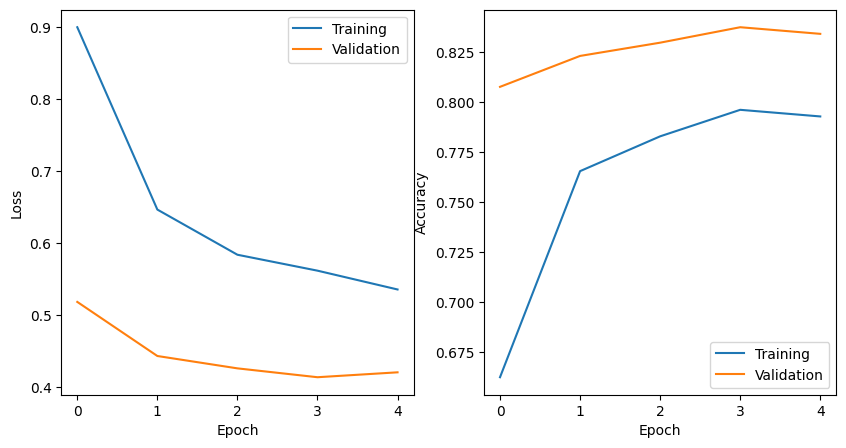

In [14]:
from plotting import plot_model_history

plot_model_history(model_history)

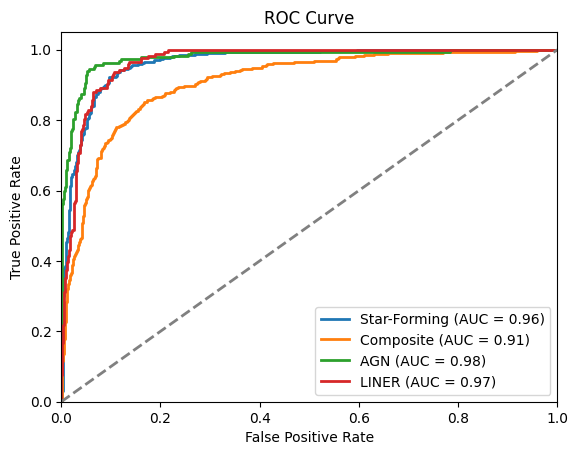

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = pred

fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

classes = ['Star-Forming', 'Composite', 'AGN', 'LINER']

for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(loc='lower right')
plt.show()
